In [1]:
from firedrake import *
import numpy as np
import scipy
from scipy.special import legendre
import matplotlib.pyplot as plt
from copy import deepcopy

a = 0                           # time of start
b = 3                           # time of end
n = 512                         # number of spatial nodes
n_steps = 154.                  # number of time steps
dt_ = (b-a)/(n_steps)           # delta t

# SDC parameters
M = 3
maxk = 3

mesh = PeriodicIntervalMesh(n, 1)
Vu = FunctionSpace(mesh, 'Lagrange', 1)
Vp = FunctionSpace(mesh, 'CG', 1)
W = MixedFunctionSpace((Vu, Vp))

U0 = Function(W)
u0, p0 = U0.split()

x1 = 0.25
x0 = 0.75
sigma = 0.1


def p_0(x, sigma=sigma):
    return exp(-x**2/sigma**2)
                 
def p_1(x, p0=p_0, sigma=sigma, k=7.2*np.pi):
    return p0(x)*cos(k*x/sigma)

def p_init(x, p0=p_0, p1=p_1, x0=x0, x1=x1, coeff=1.):
    return p_0(x-x0) + coeff*p_1(x-x1)

x = SpatialCoordinate(mesh)[0]
p0.interpolate(p_init(x))

solution = [deepcopy(U0), deepcopy(U0)]
# problem specific constants
c_s = Constant(1)                   # speed of sound
u_mean = Constant(0.05)                  # mean flow

w, phi = TestFunctions(W)
u, p = TrialFunctions(W)

Uf = Function(W)
u1, p1 = split(Uf)
dt = Constant(dt_)

F = (w * (u1 - u0) + phi * (p1 - p0)) * dx + dt * c_s * (w * p1.dx(0) + phi * u1.dx(0)) * dx
fast_problem = NonlinearVariationalProblem(F, Uf)
fast_solver = NonlinearVariationalSolver(fast_problem)

Us = Function(W)
aslow = (w * u + phi * p) * dx
Lslow = (w * u0 + phi * p0) * dx - dt * u_mean * (w * u0.dx(0) + phi * p0.dx(0)) * dx
slow_problem = LinearVariationalProblem(aslow, Lslow, Us)
slow_solver = LinearVariationalSolver(slow_problem)

outfile = File("acoustic.pvd")

Unodes = [Function(W)]*(M+1)
Unodes1 = [Function(W)]*(M+1)

def matmul_UFL(a, b):
    import numpy as np
    from firedrake import assemble
    # b is nx1 array!
    n = np.shape(a)[0]
    result = [float(0)]*n
    for j in range(n):
        for k in range(n):
            result[j] += float(a[j,k])*b[k]
        result[j] = assemble(result[j])
    return result

def IMEX(Un, dtau):

    n = len(dtau)
    Unodes[0].assign(Un)
    Uf.assign(Un)
    for i in range(n):
        dt.assign(dtau[i])
        U0.assign(Uf)
        slow_solver.solve()
        U0.assign(Us)
        fast_solver.solve()
        U0.assign(Uf)
        Unodes[i+1].assign(Uf) #for some reason this leads to Unodes being all the same
    
        
def IMEX(Un, dtau):

    n = len(dtau)
    Unodes[0] = deepcopy(Un) # this must be Uf not Un
    Uf.assign(Un)
    for i in range(n):
        dt.assign(dtau[i])
        U0.assign(Uf)
        slow_solver.solve()
        U0.assign(Us)
        fast_solver.solve()
        U0.assign(Uf)
        Unodes[i+1] = deepcopy(Uf)
    return Unodes


def rnw_r(n, a, b, A=-1, B=1):
    # nodes and weights for gauss - radau IIA quadrature
    # See Abramowitz & Stegun p 888
    nodes = np.zeros(n)
    nodes[0] = A
    p = np.poly1d([1, 1])
    pn = legendre(n)
    pn1 = legendre(n-1)
    poly, remainder = (pn + pn1)/p  # [1] returns remainder from polynomial division
    nodes[1:] = np.sort(poly.roots)
    weights = 1/n**2 * (1-nodes[1:])/(pn1(nodes[1:]))**2
    weights = np.append(2/n**2, weights)
    nodes = ((b - a) * nodes + a * B - b * A) / (B - A)
    weights = (b - a)/(B - A)*weights
    nodes = ((b + a) - nodes)[::-1]  # reverse nodes
    weights = weights[::-1]  # reverse weights
    return nodes, weights


def NewtonVM(t):
    """
    t: array or list containing nodes.
    returns: array Newton Vandermode Matrix. Entries are in the lower
    triangle
    Polynomial can be created with
    scipy.linalg.solve_triangular(NewtonVM(t),y,lower=True) where y
    contains the points the polynomial need to pass through
    """
    t = np.asarray(t)
    dim = len(t)
    VM = np.zeros([dim, dim])
    VM[:, 0] = 1
    for i in range(1, dim):
        VM[:, i] = (t[:] - t[(i - 1)]) * VM[:, i - 1]

    return VM


def Horner_newton(weights, xi, x):
    """
    Horner scheme to evaluate polynomials based on newton basis
    """
    y = np.zeros_like(x)
    for i in range(len(weights)):
        y = y * (x - xi[(-i - 1)]) + weights[(-i - 1)]

    return y


def nodes_weights(n, a, b, A=-1, B=1):
    # nodes and weights for gauss legendre quadrature
    from scipy.special import legendre
    import numpy as np
    poly = legendre(n)
    polyd = poly.deriv()
    nodes= poly.roots
    nodes = np.sort(nodes)
    weights = 2/((1-nodes**2)*(np.polyval(polyd,nodes))**2)
    nodes = ((b - a) * nodes + a * B - b * A) / (B - A)
    weights=(b-a)/(B-A)*weights
    return nodes, weights


def get_weights(n, a, b, nodes, nodes_weights=nodes_weights, NewtonVM=NewtonVM, Horner_newton=Horner_newton, eval=eval):
    # integrates lagrange polynomials to the points [nodes]
    nodes_m, weights_m=nodes_weights(np.ceil(n/2), a, b)  # use gauss-legendre quadrature to integrate polynomials
    weights = np.zeros(n)
    for j in np.arange(n):
        coeff = np.zeros(n)
        coeff[j] = 1.0  # is unity because it needs to be scaled with y_j for interpolation we have  sum y_j*l_j
        poly_coeffs = scipy.linalg.solve_triangular(NewtonVM(nodes), coeff, lower=True)
        eval_newt_poly = Horner_newton(poly_coeffs, nodes, nodes_m)
        weights[j] = np.dot(weights_m, eval_newt_poly)
    return weights


def Qmatrix(nodes, a):
    """
    Integration Matrix 
    """
    M = len(nodes)
    Q = np.zeros([M, M])

    # for all nodes, get weights for the interval [tleft,node]
    for m in np.arange(M):
        w = get_weights(M, a, nodes[m],nodes)
        Q[m, 0:] = w

    return Q


def Smatrix(Q):
    """
    Integration matrix based on Q: sum(S@vector) returns integration
    """
    from copy import deepcopy
    M = len(Q)
    S = np.zeros([M, M])

    S[0, :] = deepcopy(Q[0, :])
    for m in np.arange(1, M):
        S[m, :] = Q[m, :] - Q[m - 1, :]

    return S

t = a
Un = Function(W)
Unp1 = Function(W)
Un.assign(U0)
un, pn = Un.split()
outfile.write(un, pn)

nodes, weights = rnw_r(M, 0, dt_)
Q = Qmatrix(nodes, 0)
S = Smatrix(Q)

Uout = Function(W)

def f(Uin):
    uin, pin = Uin.split()
    a = w * u * dx + phi * p * dx
    L = -c_s * (w * pin.dx(0) + phi * uin.dx(0)) * dx - u_mean * (w * uin.dx(0) + phi * pin.dx(0)) * dx
    solve(a == L, Uout)
    return Uout

U_SDC = Function(W)
u11, p11 = split(U_SDC)
U01 = Function(W)
u01, p01 = U01.split()
Q_ = Function(W)
q0, q1 = Q_.split()

F_SDC = (w * (u11 - un) + phi * (p11 - pn)) * dx - dt * (
    -c_s * (w * (p11.dx(0) - p01.dx(0)) + phi * (u11.dx(0) - u01.dx(0))) * dx
    - u_mean * (w * (un.dx(0) - u0.dx(0)) + phi * (pn.dx(0) - p0.dx(0))) * dx
    ) - (w * q0 + phi * q1) * dx
prob_SDC = NonlinearVariationalProblem(F_SDC, U_SDC)
solve_SDC = NonlinearVariationalSolver(prob_SDC)

dtau = np.diff(np.append(a, nodes))
k = 0

count = 0
"""
TODO: compare SDC iterations myversion vs new version, IMEX should work now
"""
while t < 154*dt_:
    #print("t: ", t)
    count += 1
    Unodes = deepcopy(IMEX(Un, dtau))
    k = 0 ### missing
    while k < maxk:
        k+=1 ### missing
        #print('were doing SDC')
        #print(Unodes[1](0.75), Unodes[2](0.75), Unodes[3](0.75))
        #print(f(Unodes[1])(0.75), f(Unodes[2])(0.75), f(Unodes[3])(0.75))

        #quad = dot(as_matrix(S),
        #           as_vector([f(Unodes[1]), f(Unodes[2]), f(Unodes[3])]))
        t1, t2, t3 =  deepcopy(f(Unodes[1])), deepcopy(f(Unodes[2])), deepcopy(f(Unodes[3]))# ALL functions in this list are the same! this is not good
        tl = [t1, t2, t3]
        #print('wtf')
        #print(tl[0](0.75), tl[1](0.75), tl[2](0.75))
        #print(f(Unodes[1])(0.75), f(Unodes[2])(0.75), f(Unodes[3])(0.75))

        quad = matmul_UFL(S,tl)
        Unodes1[0].assign(Unodes[0]) # is redundant with each new iteration because u(t_n) does not change
        for m in range(1, M+1):
            dt.assign(dtau[m-1])
            U0.assign(Unodes[m-1])
            U01.assign(Unodes[m])
            Un.assign(Unodes1[m-1])
            Q_.assign(quad[m-1])
            solve_SDC.solve()
            #print(U_SDC.dat.data.min(), U_SDC.dat.data.max())
            Unodes1[m] = deepcopy(U_SDC) # assignment does not work the way it should!
        Unodes = deepcopy(Unodes1) # deepcopy makes a difference. with deepcopy -> more diffusion
                                   # idea: everytime Unodes(Unodes1) is changed, Unodes1(Unodes) must also change due to
                                   # memory dependency. Maybe this happens elsewhere when doing assign...


    Un.assign(Unodes1[-1])
    un, pn = Un.split()
    t += dt_
    solution.append(deepcopy(Un))
    #outfile.write(un, pn)

solution = solution[1:]

/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


/prog/firedrake/src/firedrake/firedrake/plot.py:808: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


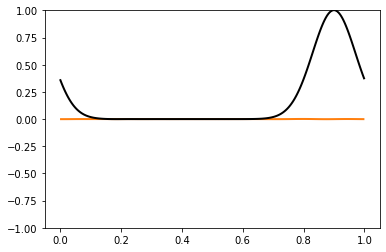

In [2]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
#axes.set_ylim((-1., 1.))
from matplotlib.animation import FuncAnimation
#tt = np.arange(0,t_end+d_t,d_t)
results = solution
def animate(U_n):
    u_n, p_n = U_n.split()
    axes.clear()
    firedrake.plot(u_n, axes=axes,color='C1')
    firedrake.plot(p_n, axes=axes)
    axes.set_ylim((-1., 1.))
    #axes.annotate('t: %.2f' % t,xy=(0.1,0.1))

interval = 5e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

In [3]:
solution[-1](0.75)
Unodes[3](0.75)
tl[2](0.75)
quad[2](0.75)

(array(-0.00201723), array(-0.02062519))

In [3]:
tl[0](0.75)

NameError: name 'tl' is not defined